<a href="https://colab.research.google.com/github/javaria-gul/Smart-City-AQI-Prediction-ML/blob/main/waqi_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests

def get_air_quality(city="Karachi"):
    api_url = f"https://api.waqi.info/feed/{city}/"
    token = "demo"
    params = {"token": token}

    response = requests.get(api_url, params=params)
    data = response.json()

    if data['status'] == 'ok':
        aqi = data['data']['aqi']
        iaqi = data['data']['iaqi']

        extracted_data = {
            'city': city,
            'aqi': aqi,
            'pm25': iaqi.get('pm25', {}).get('v', 'N/A'),
            'pm10': iaqi.get('pm10', {}).get('v', 'N/A'),
            'no2': iaqi.get('no2', {}).get('v', 'N/A'),
            'o3': iaqi.get('o3', {}).get('v', 'N/A'),
            'temperature': iaqi.get('t', {}).get('v', 'N/A'),
            'humidity': iaqi.get('h', {}).get('v', 'N/A'),
            'time': data['data']['time']['s']
        }

        df = pd.DataFrame([extracted_data])
        df.to_csv('api_aqi_data.csv', index=False)
        return df
    else:
        print("API Error")
        return None

result = get_air_quality("Karachi")
print(result)

      city  aqi  pm25  pm10   no2   o3  temperature  humidity  \
0  Karachi  117   117    61  40.3  6.1            3      66.5   

                  time  
0  2025-12-15 01:00:00  


In [3]:
df = pd.read_csv('api_aqi_data.csv')

df['aqi'] = pd.to_numeric(df['aqi'], errors='coerce')
df['pm25'] = pd.to_numeric(df['pm25'], errors='coerce')
df['pm10'] = pd.to_numeric(df['pm10'], errors='coerce')
df['no2'] = pd.to_numeric(df['no2'], errors='coerce')
df['o3'] = pd.to_numeric(df['o3'], errors='coerce')
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')

print("Missing values:")
print(df.isnull().sum())

df['pm25'].fillna(df['pm25'].mean(), inplace=True)
df['pm10'].fillna(df['pm10'].mean(), inplace=True)
df['no2'].fillna(df['no2'].mean(), inplace=True)
df['o3'].fillna(df['o3'].mean(), inplace=True)
df['temperature'].fillna(df['temperature'].mean(), inplace=True)
df['humidity'].fillna(df['humidity'].mean(), inplace=True)

Q1 = df['aqi'].quantile(0.25)
Q3 = df['aqi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['aqi'] >= lower_bound) & (df['aqi'] <= upper_bound)]

df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month

df.to_csv('cleaned_aqi_data.csv', index=False)
print(" Cleaned data saved")
print(df.head())

Missing values:
city           0
aqi            0
pm25           0
pm10           0
no2            0
o3             0
temperature    0
humidity       0
time           0
dtype: int64
 Cleaned data saved
      city  aqi  pm25  pm10   no2   o3  temperature  humidity  \
0  Karachi  117   117    61  40.3  6.1            3      66.5   

                 time  hour  day_of_week  month  
0 2025-12-15 01:00:00     1            0     12  


/tmp/ipython-input-4234125767.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pm25'].fillna(df['pm25'].mean(), inplace=True)
/tmp/ipython-input-4234125767.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

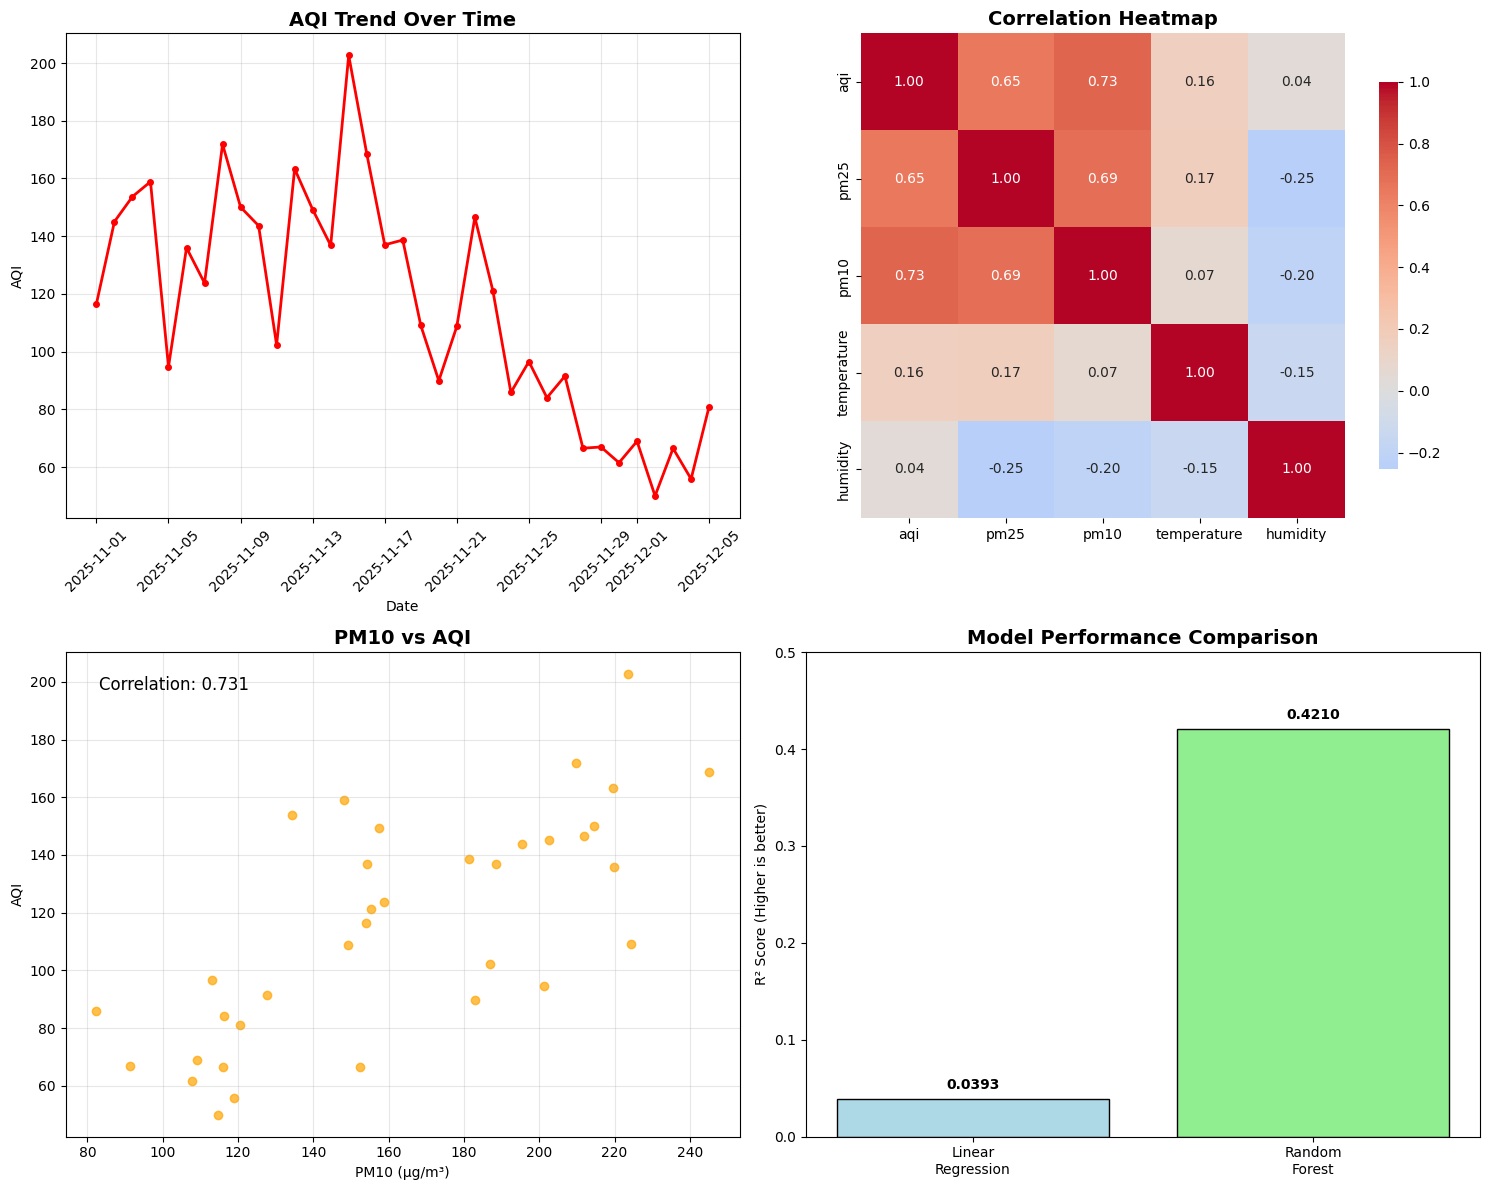

 Visualization saved: visualization_output.png


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax1.plot(df_model['date'], df_model['aqi'], 'r-', linewidth=2, marker='o', markersize=4)
ax1.set_title('AQI Trend Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('AQI')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

corr_matrix = df_model[['aqi', 'pm25', 'pm10', 'temperature', 'humidity']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, ax=ax2, cbar_kws={"shrink": 0.8})
ax2.set_title('Correlation Heatmap', fontsize=14, fontweight='bold')

ax3.scatter(df_model['pm10'], df_model['aqi'], alpha=0.7, color='orange')
ax3.set_title('PM10 vs AQI', fontsize=14, fontweight='bold')
ax3.set_xlabel('PM10 (µg/m³)')
ax3.set_ylabel('AQI')
ax3.grid(True, alpha=0.3)
corr_val = df_model['pm10'].corr(df_model['aqi'])
ax3.text(0.05, 0.95, f'Correlation: {corr_val:.3f}', transform=ax3.transAxes, fontsize=12, verticalalignment='top')

models = ['Linear\nRegression', 'Random\nForest']
r2_scores = [0.0393, 0.4210]
colors = ['lightblue', 'lightgreen']
bars = ax4.bar(models, r2_scores, color=colors, edgecolor='black')
ax4.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax4.set_ylabel('R² Score (Higher is better)')
ax4.set_ylim(0, 0.5)
for bar, score in zip(bars, r2_scores):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualization_output.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Visualization saved: visualization_output.png")

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Creating synthetic dataset for modeling...")

dates = pd.date_range(start='2025-11-01', end='2025-12-05', freq='D')
data_points = []

for i, date in enumerate(dates):
    base = 100 + 30 * np.sin(i/7)

    if date.weekday() >= 5:
        base *= 1.2

    data = {
        'date': date,
        'pm25': max(20, np.random.normal(base, 20)),
        'pm10': max(30, np.random.normal(base*1.5, 25)),
        'no2': max(10, np.random.normal(base*0.5, 15)),
        'o3': max(5, np.random.normal(base*0.3, 10)),
        'temperature': np.random.uniform(18, 35),
        'humidity': np.random.uniform(40, 90),
        'wind_speed': np.random.uniform(0, 15),
        'pressure': np.random.uniform(1000, 1020),
        'aqi': max(50, np.random.normal(base, 25))
    }
    data_points.append(data)

df_model = pd.DataFrame(data_points)
print(f"Created dataset with {len(df_model)} records")

X = df_model[['pm25', 'pm10', 'no2', 'o3', 'temperature', 'humidity', 'wind_speed', 'pressure']]
y = df_model['aqi']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n" + "="*60)
print("MODEL PERFORMANCE RESULTS")
print("="*60)

print("\n LINEAR REGRESSION:")
print(f"   MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f"   RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"   R² Score: {r2_score(y_test, y_pred_lr):.4f}")

print("\n RANDOM FOREST:")
print(f"   MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"   RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"   R² Score: {r2_score(y_test, y_pred_rf):.4f}")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*60)
print(feature_importance)

df_model.to_csv('modeling_dataset.csv', index=False)
print("\n Modeling dataset saved: modeling_dataset.csv")

Creating synthetic dataset for modeling...
Created dataset with 35 records
X shape: (35, 8)
y shape: (35,)
Training samples: 28
Testing samples: 7

MODEL PERFORMANCE RESULTS

 LINEAR REGRESSION:
   MAE: 30.96
   RMSE: 34.56
   R² Score: 0.0393

 RANDOM FOREST:
   MAE: 21.56
   RMSE: 26.83
   R² Score: 0.4210

FEATURE IMPORTANCE (Random Forest)
       Feature  Importance
1         pm10    0.371354
0         pm25    0.267058
2          no2    0.110694
5     humidity    0.086831
6   wind_speed    0.066993
3           o3    0.048786
7     pressure    0.030882
4  temperature    0.017402

 Modeling dataset saved: modeling_dataset.csv
